In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lbg_forecast.priors_gp_dust as gpdp

In [2]:
dust_prior = gpdp.DustPrior('./')
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

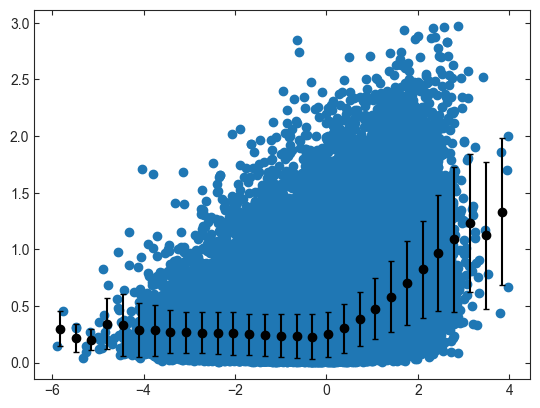

In [3]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -6, 4, 30)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)

10.696788364811846
7.713449658712004
5.1753217685500355
3.169124027375023
1.7682970037125099
1.0095853930162724
0.8323153564409232
0.7890946150130841
0.7457766639149407
0.7022934223492371
0.6586071613510223
0.6147012770983578
0.5705744110141666
0.5262364319666377
0.4817054838533577
0.4370056418537174
0.3921649052323675
0.3472133703461391
0.30218151806196114
0.2570986367071193
0.21199148714724259
0.1668833787972214
0.12179382017239658
0.07673879437784217
0.03173150272924029
-0.013216780432343525
-0.058096152482724886
-0.10289808245747599
-0.1476159343899024
-0.19224571392033954
-0.23678660213902727
-0.28124086471030924
-0.32561287699393016
-0.3699072349244245
-0.41412616854123535
-0.4582666780597019
-0.5023179145419177
-0.5462592968299834
-0.5900597027229196
-0.6336778442672357
-0.677063702527597
-0.7201607163741035
-0.7629083259453002
-0.8052444674679446
-0.8471076830128649
-0.8884386178582887
-0.9291808010877805
-0.9692807194367042
-1.008687285506912
-1.0473508620195986
-1.08522203274

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


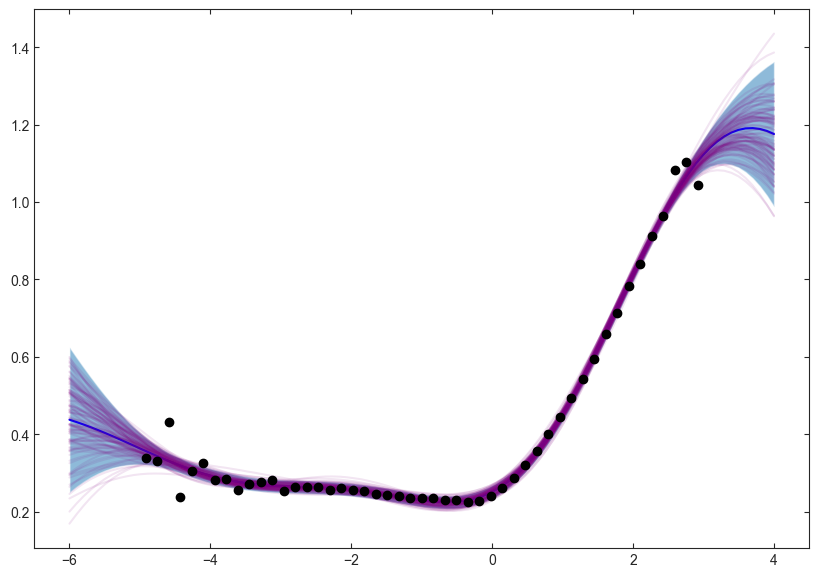

In [4]:
train_sfrs, train_dust2, train_dust2_errs = dust_prior.process_training_data_dust2()
test_sfrs = torch.linspace(-6, 4, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [1.0, 15.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [5]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

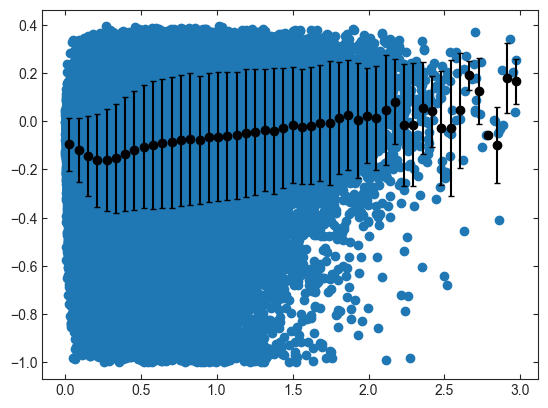

In [6]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(9999999999)
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)

175.27359279766614
161.83302812886083
148.31295846915765
134.80061076847412
121.39134440944474
108.1877722756517
95.29849492472233
82.83640591341089
70.9165328645062
59.653388575905964
49.157820683781765
39.53336984487078
30.87217902279931
23.250544951693392
16.724272008871385
11.324081464450591
7.051443108882437
3.8753187913792204
1.7304100759635994
0.5175388726662115
0.10670342943026487
0.058214292326409074
0.009711335173426214
-0.03887380406587717
-0.08750519337017906
-0.13614380076185126
-0.18474772110106272
-0.2332722961648826
-0.28167014895221626
-0.3298911487929353
-0.377882322173583
-0.42558772418275437
-0.4729482801773657
-0.5199016130809089
-0.5663818571018354
-0.6123194870258233
-0.6576411573806923
-0.7022695744331671
-0.7461234111406326
-0.7891172753898198
-0.8311617520799308
-0.8721635265274047
-0.9120256056202788
-0.950647658637684
-0.9879264896017766
-1.0237566733731716
-1.0580313838065623
-1.090643457479593
-1.1214867479428783
-1.1504578341219511
-1.177458146651787
-1.2

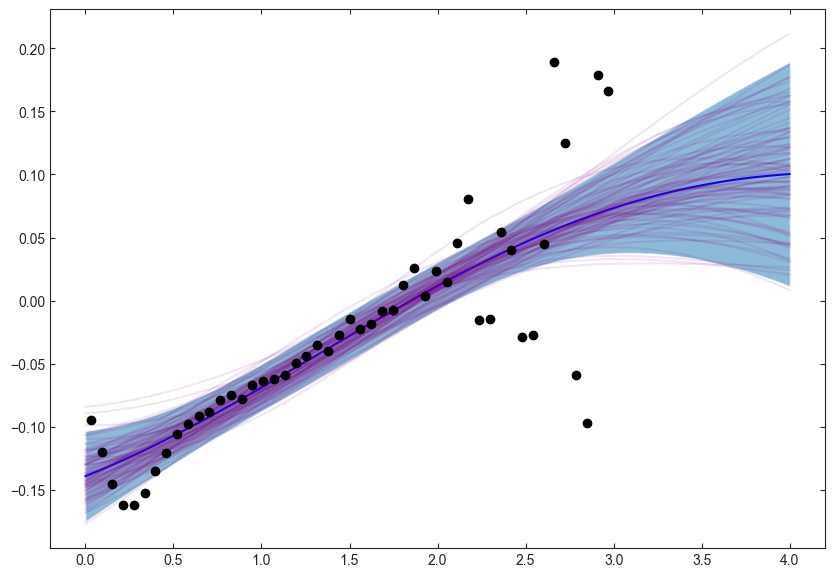

In [7]:
train_dust2, train_dust_index, train_dust_index_errs = dust_prior.process_training_data_dust_index()

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [8]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

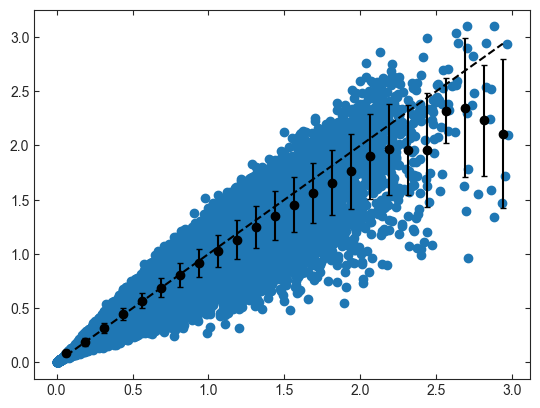

In [9]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

175.3249835357716
161.88740310479022
148.37076561434148
134.86224466154906
121.45701563766669
108.2575171905331
95.37231300202434
82.91432684799518
70.99862937805786
59.739775512623176
49.24865201348941
39.62883580080362
30.97250372911052
23.35598464893684
16.835113993036412
11.44064390276798
7.174075913678992
4.004405783353346
1.866372690184391
0.6608416549611509
0.25786149326206126
0.21789829851829387
0.17859537860688318
0.13996167482203137
0.10211728001777337
0.06519023972349612
0.02931585919541466
-0.005363994727729227
-0.03870174092585664
-0.07054524129080886
-0.10073941278706831
-0.1291284411554924
-0.15555874147411666
-0.17988280540573195
-0.2019640282081139
-0.22168259423025855
-0.2389423572614904
-0.25367860808564197
-0.2658663797306922
-0.2755287129269726
-0.282744116843342
-0.28765213746353124
-0.29045579683101785
-0.29141964538668474
-0.2908623697551201
-0.28914356080145215
-0.28664492000993386
-0.2837474746080166
-0.2808071023751498
-0.27813149714857144
-0.2759616399172583

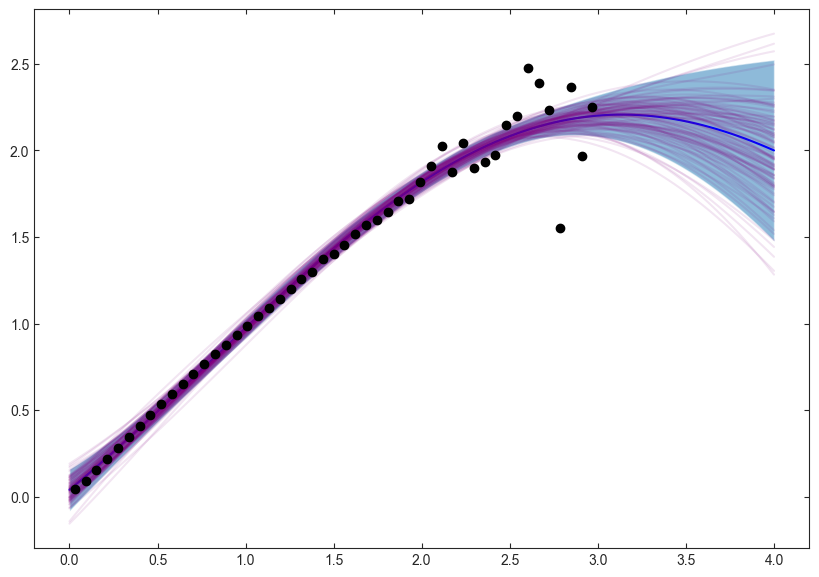

In [10]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = dust_prior.process_training_data_dust1()
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=1000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [11]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')